In [1]:
import IPython
import glob
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import librosa
import sys ; sys.path.append('../')
from model.network_architecture import autoencoder
from tqdm import tqdm
from evaluacion import *

2021-09-17 09:36:13.317906: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [160]:
CARPETA = '/home/martin/deep-dereverb/model/ckpts/'
pesos = glob.glob(CARPETA+'*.hdf5')
pesos.sort()
PESOS = '/home/martin/deep-dereverb/model/ckpts/reales/weights.03-0.0028.hdf5'
#PESOS = pesos[-1]
modelo = autoencoder()
modelo.load_weights(PESOS)

In [161]:
reverb_list = glob.glob('/home/martin/deep-dereverb/data/test/real/**/*.npy', recursive=True)
clean_list =glob.glob('/home/martin/deep-dereverb/data/test/clean/**/*.npy', recursive=True)
reverb_list.sort(); clean_list.sort()

In [162]:
audio_in = np.load(reverb_list[45])
audio_target = np.load(clean_list[45])
espectro_in = gen_stft(audio_in)
espectro_target = gen_stft(audio_target)

In [163]:
espectro_out = modelo.predict([espectro_in.reshape(1,256,256)])
espectro_out = espectro_out.reshape(256,256)

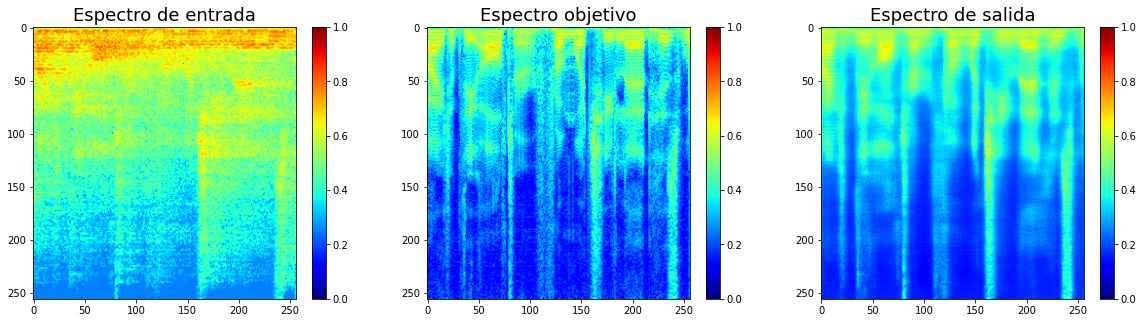

In [164]:
plt.figure(1, figsize=(20,5))
plt.subplot(1,3,1);plt.title('Espectro de entrada', size=18)
plt.imshow(espectro_in, aspect='auto', vmin=0, vmax=1, cmap='jet');plt.colorbar()
plt.subplot(1,3,2);plt.title('Espectro objetivo', size=18)
plt.imshow(espectro_target, aspect='auto', vmin=0, vmax=1, cmap='jet');plt.colorbar()
plt.subplot(1,3,3);plt.title('Espectro de salida', size=18) 
plt.imshow(espectro_out, aspect='auto', vmin=0, vmax=1, cmap='jet');plt.colorbar()
plt.savefig('funcionamiento.png')

In [165]:
def frame_to_raw_f(frame, reverb):
    stft_reverb = librosa.stft(reverb, n_fft=512, hop_length=128)#[:-1,:]# Descarto altas frecuencias
    pha_reverb = np.angle(stft_reverb)


    frame = denormalise(frame)
    #Escala logaritmica
    frame_lin = librosa.db_to_amplitude(frame)

    #Necesito agregar el bin de frecuencia que le saque.
    frame_lin_pad = np.pad(frame_lin,((0,1),(0,0)), 'minimum') #Ojoooooo!

    stft_build = frame_lin_pad * np.exp(1j*pha_reverb)
    recover = librosa.istft(stft_build, hop_length=128, win_length=512)
    return recover

In [172]:
audio_in= frame_to_raw(espectro_in)
audio_out = frame_to_raw(espectro_out)
audio_target = frame_to_raw(espectro_target)

#audio_in= frame_to_raw_f(espectro_in, audio_in)
#audio_out = frame_to_raw_f(espectro_out, audio_in)
#audio_target = frame_to_raw_f(espectro_target, audio_target)

In [173]:
fs = 16000
print('Audio con reverb (entrada)')
IPython.display.display(IPython.display.Audio(audio_in, rate=fs))
print('Audio anecoico (objetivo)')
IPython.display.display(IPython.display.Audio(audio_target, rate=fs))
print('Audio dereverberado (resultado)')
IPython.display.display(IPython.display.Audio(audio_out, rate=fs))

Audio con reverb (entrada)


Audio anecoico (objetivo)


Audio dereverberado (resultado)


# Evaluando metricas

In [174]:
def get_metricas(clean, reverb, fs):
    SRMR = srmr.srmr(reverb, fs)[0]
    SDR, _, _, _ = mir_eval.separation.bss_eval_sources(clean, reverb, compute_permutation=True)
    ESTOI = pystoi.stoi(clean, reverb, fs, extended = True)
    print('SDR: {}\t SRMR: {}\t ESTOI: {}'.format(SDR, SRMR, ESTOI))
    return SRMR, SDR, ESTOI
_ = get_metricas(audio_target, audio_in, 16000)
_ = get_metricas(audio_target, audio_out, 16000)

SDR: [-7.97589075]	 SRMR: 1.2534356451171849	 ESTOI: 0.23699145906319846
SDR: [-7.05373828]	 SRMR: 4.381797165907835	 ESTOI: 0.639241773243946


In [156]:
indices = np.random.choice(np.arange(0,len(reverb_list)), 100)

SRMR_reverb = []                                                                                                                         
SDR_reverb = []                                                                                                                          
ESTOI_reverb = []                                                                                                                        

SRMR_dereverb = []                                                                                                                       
SDR_dereverb = []                                                                                                                        
ESTOI_dereverb = [] 

for i in tqdm(indices):
    audio_in = np.load(reverb_list[i])
    audio_target = np.load(clean_list[i])
    
    espectro_in = gen_stft(audio_in)
    espectro_target = gen_stft(audio_target)
    
    espectro_out = modelo.predict([espectro_in.reshape(1,256,256)])
    espectro_out = espectro_out.reshape(256,256)
    
    dereverb = frame_to_raw_f(espectro_out, audio_in)
    clean = frame_to_raw_f(espectro_target, audio_target)
    reverb = frame_to_raw_f(espectro_in, audio_in)
    
    # get metriciis for clean-reverb                                                                                                       
    srmr_, sdr, estoi = get_metricas(clean, reverb, fs)                                                                                   
    SRMR_reverb.append(srmr_)                                                                                                             
    SDR_reverb.append(sdr)                                                                                                               
    ESTOI_reverb.append(estoi)                                                                                                           

    # get metrics for clean-dereverb                                                                                                     
    srmr_, sdr, estoi = get_metricas(clean, dereverb, fs)                                                                                 
    SRMR_dereverb.append(srmr_)                                                                                                           
    SDR_dereverb.append(sdr)                                                                                                             
    ESTOI_dereverb.append(estoi)
    
    

  1%|█                                                                                                       | 1/100 [00:00<00:42,  2.36it/s]

SDR: [-4.96423954]	 SRMR: 1.3355689608016228	 ESTOI: 0.20212203908309975
SDR: [1.60128131]	 SRMR: 6.042489693741782	 ESTOI: 0.3653766625332259


  2%|██                                                                                                      | 2/100 [00:00<00:36,  2.66it/s]

SDR: [-4.96485783]	 SRMR: 1.6269063568774143	 ESTOI: 0.20227062501066495
SDR: [-2.92856532]	 SRMR: 3.3771517517892153	 ESTOI: 0.3137910853944481


  3%|███                                                                                                     | 3/100 [00:01<00:37,  2.58it/s]

SDR: [-4.04108134]	 SRMR: 1.5580131500725423	 ESTOI: 0.27338060873500375
SDR: [-0.59333223]	 SRMR: 5.210199959309683	 ESTOI: 0.4110206210893106


  4%|████▏                                                                                                   | 4/100 [00:01<00:37,  2.55it/s]

SDR: [3.28968492]	 SRMR: 2.865053408900511	 ESTOI: 0.42959624830258203
SDR: [5.3185625]	 SRMR: 11.083545776762112	 ESTOI: 0.6255599294547585


  5%|█████▏                                                                                                  | 5/100 [00:01<00:37,  2.56it/s]

SDR: [-1.83229055]	 SRMR: 2.1378777495478816	 ESTOI: 0.3053462353249404
SDR: [2.98427529]	 SRMR: 7.2595943722712235	 ESTOI: 0.39068924012875494


  6%|██████▏                                                                                                 | 6/100 [00:02<00:35,  2.67it/s]

SDR: [-4.98990599]	 SRMR: 1.0235137178970317	 ESTOI: 0.05152428181162111
SDR: [0.01984408]	 SRMR: 2.9467586684239255	 ESTOI: 0.2375921262901064


  7%|███████▎                                                                                                | 7/100 [00:02<00:34,  2.71it/s]

SDR: [-4.02947274]	 SRMR: 1.2338145357237076	 ESTOI: 0.32226441631033076
SDR: [0.50207253]	 SRMR: 5.506446848251155	 ESTOI: 0.4658877321574539


  8%|████████▎                                                                                               | 8/100 [00:03<00:34,  2.70it/s]

SDR: [-5.14127559]	 SRMR: 1.4613878869546393	 ESTOI: 0.24869906845336068
SDR: [-2.04508767]	 SRMR: 3.848660294685344	 ESTOI: 0.4099760871473436


  9%|█████████▎                                                                                              | 9/100 [00:03<00:33,  2.68it/s]

SDR: [-3.61577055]	 SRMR: 1.31825741296826	 ESTOI: 0.27114204968312855
SDR: [-2.76245219]	 SRMR: 3.4897494122062946	 ESTOI: 0.4467399553030523


 10%|██████████▎                                                                                            | 10/100 [00:03<00:33,  2.68it/s]

SDR: [-2.10635738]	 SRMR: 1.3096754914362212	 ESTOI: 0.36645783654784053
SDR: [-0.73790617]	 SRMR: 2.410269213755548	 ESTOI: 0.5618097002924864


 11%|███████████▎                                                                                           | 11/100 [00:04<00:32,  2.70it/s]

SDR: [0.12327015]	 SRMR: 2.991998704041381	 ESTOI: 0.3752354106688254
SDR: [5.09910651]	 SRMR: 9.177984659837241	 ESTOI: 0.4500996910137681


 12%|████████████▎                                                                                          | 12/100 [00:04<00:33,  2.67it/s]

SDR: [-4.44212031]	 SRMR: 1.4204870229564837	 ESTOI: 0.19335919752757216
SDR: [-1.77553709]	 SRMR: 4.5114423624296265	 ESTOI: 0.3455792564397134


 13%|█████████████▍                                                                                         | 13/100 [00:04<00:32,  2.68it/s]

SDR: [-1.67644464]	 SRMR: 2.112887070259681	 ESTOI: 0.2850590556477099
SDR: [0.93197494]	 SRMR: 5.166908901587575	 ESTOI: 0.40989910803183516


 14%|██████████████▍                                                                                        | 14/100 [00:05<00:32,  2.67it/s]

SDR: [-5.31769118]	 SRMR: 1.9978950976514602	 ESTOI: 0.25579916087076965
SDR: [-3.69061708]	 SRMR: 7.380086854854736	 ESTOI: 0.47757024647951196


 15%|███████████████▍                                                                                       | 15/100 [00:05<00:32,  2.61it/s]

SDR: [0.65421971]	 SRMR: 2.6906944891479534	 ESTOI: 0.500899841012118
SDR: [3.70387283]	 SRMR: 7.846904926794894	 ESTOI: 0.596525943495899


 16%|████████████████▍                                                                                      | 16/100 [00:06<00:32,  2.58it/s]

SDR: [1.76477506]	 SRMR: 2.686589222294504	 ESTOI: 0.3409869895038382
SDR: [3.57247235]	 SRMR: 11.085730642453969	 ESTOI: 0.5155899014615132


 17%|█████████████████▌                                                                                     | 17/100 [00:06<00:32,  2.57it/s]

SDR: [-6.30590074]	 SRMR: 1.4733961855146522	 ESTOI: 0.20138153168885028
SDR: [-5.21457865]	 SRMR: 3.4885482703704023	 ESTOI: 0.42610294630556206


 18%|██████████████████▌                                                                                    | 18/100 [00:06<00:32,  2.51it/s]

SDR: [-1.9736709]	 SRMR: 1.8820955770125123	 ESTOI: 0.12010575017678124
SDR: [1.94351314]	 SRMR: 6.1402536782705015	 ESTOI: 0.34708628747046855


 19%|███████████████████▌                                                                                   | 19/100 [00:07<00:31,  2.61it/s]

SDR: [-3.45811685]	 SRMR: 1.6884580878777882	 ESTOI: 0.3848411243956301
SDR: [-1.51786836]	 SRMR: 5.57150110796014	 ESTOI: 0.4640253265679063


 20%|████████████████████▌                                                                                  | 20/100 [00:07<00:30,  2.58it/s]

SDR: [-4.41137748]	 SRMR: 1.9606991890597447	 ESTOI: 0.27966125207653564
SDR: [-0.93038393]	 SRMR: 6.442587156680963	 ESTOI: 0.4227105334617503


 21%|█████████████████████▋                                                                                 | 21/100 [00:08<00:30,  2.58it/s]

SDR: [-0.86857694]	 SRMR: 1.8225611248723617	 ESTOI: 0.4157465033140057
SDR: [1.18068568]	 SRMR: 8.704301958554774	 ESTOI: 0.6364566710148383


 22%|██████████████████████▋                                                                                | 22/100 [00:08<00:30,  2.58it/s]

SDR: [-3.79273057]	 SRMR: 1.2963444388925225	 ESTOI: 0.22173267800268795
SDR: [-1.07212218]	 SRMR: 3.0732419148428396	 ESTOI: 0.3693698852251814


 23%|███████████████████████▋                                                                               | 23/100 [00:08<00:30,  2.55it/s]

SDR: [-2.27726272]	 SRMR: 1.3711837685559352	 ESTOI: 0.16644408696865998
SDR: [-1.5640398]	 SRMR: 3.673948893793816	 ESTOI: 0.31791001503325594


 24%|████████████████████████▋                                                                              | 24/100 [00:09<00:29,  2.56it/s]

SDR: [-2.10264716]	 SRMR: 2.4753960807473696	 ESTOI: 0.469621291265269
SDR: [-2.04251661]	 SRMR: 4.252600585445499	 ESTOI: 0.6354850930737777


 25%|█████████████████████████▊                                                                             | 25/100 [00:09<00:29,  2.53it/s]

SDR: [0.28931717]	 SRMR: 1.3979823899482404	 ESTOI: 0.3276994879401789
SDR: [2.35339364]	 SRMR: 3.0849221955286645	 ESTOI: 0.4201492284851242


 26%|██████████████████████████▊                                                                            | 26/100 [00:09<00:29,  2.54it/s]

SDR: [-2.17831838]	 SRMR: 1.3506694540945936	 ESTOI: 0.3834192732281284
SDR: [-0.95109826]	 SRMR: 3.921258034641581	 ESTOI: 0.5629674867671612


 27%|███████████████████████████▊                                                                           | 27/100 [00:10<00:28,  2.56it/s]

SDR: [-1.51277221]	 SRMR: 1.565244634707591	 ESTOI: 0.2764693066169504
SDR: [0.09776941]	 SRMR: 4.415892416938179	 ESTOI: 0.4524080043664235


 28%|████████████████████████████▊                                                                          | 28/100 [00:10<00:28,  2.57it/s]

SDR: [-4.19281885]	 SRMR: 0.9639697661452749	 ESTOI: 0.18942302335389186
SDR: [-0.17982265]	 SRMR: 4.161619609908196	 ESTOI: 0.44824619817304984


 29%|█████████████████████████████▊                                                                         | 29/100 [00:11<00:27,  2.56it/s]

SDR: [-4.83196075]	 SRMR: 1.15459674298414	 ESTOI: 0.26977054281573004
SDR: [-0.45875729]	 SRMR: 5.330792562331971	 ESTOI: 0.4050388779037025


 30%|██████████████████████████████▉                                                                        | 30/100 [00:11<00:27,  2.54it/s]

SDR: [-2.9211391]	 SRMR: 1.901066246840003	 ESTOI: 0.21645729371537284
SDR: [2.55112954]	 SRMR: 10.114411962024835	 ESTOI: 0.3577571801564156


 31%|███████████████████████████████▉                                                                       | 31/100 [00:11<00:26,  2.57it/s]

SDR: [-2.4377691]	 SRMR: 1.5611892416257191	 ESTOI: 0.3362136585813497
SDR: [1.74659883]	 SRMR: 7.774357599496057	 ESTOI: 0.4789315623025321


 32%|████████████████████████████████▉                                                                      | 32/100 [00:12<00:26,  2.60it/s]

SDR: [-2.99888249]	 SRMR: 1.0960118346452852	 ESTOI: 0.207733262703269
SDR: [-1.60878138]	 SRMR: 3.4935325083363753	 ESTOI: 0.3711416247058213


 33%|█████████████████████████████████▉                                                                     | 33/100 [00:12<00:25,  2.63it/s]

SDR: [-2.34288707]	 SRMR: 1.5488417195230653	 ESTOI: 0.25859842056577
SDR: [2.41604187]	 SRMR: 7.758878388086858	 ESTOI: 0.4341165415898909


 34%|███████████████████████████████████                                                                    | 34/100 [00:13<00:24,  2.66it/s]

SDR: [-5.56899682]	 SRMR: 1.9446163609245404	 ESTOI: 0.06626621795694078
SDR: [0.0643554]	 SRMR: 4.879032265736742	 ESTOI: 0.1672870200131352


 35%|████████████████████████████████████                                                                   | 35/100 [00:13<00:24,  2.64it/s]

SDR: [-5.25506844]	 SRMR: 1.5492187754308886	 ESTOI: 0.09798598306520312
SDR: [-3.17803442]	 SRMR: 4.101397180953995	 ESTOI: 0.28809971466793716


 36%|█████████████████████████████████████                                                                  | 36/100 [00:13<00:24,  2.62it/s]

SDR: [-5.92611822]	 SRMR: 0.9946684990256135	 ESTOI: 0.20871252557898318
SDR: [-3.0533277]	 SRMR: 4.487455300723939	 ESTOI: 0.38840661286561323


 37%|██████████████████████████████████████                                                                 | 37/100 [00:14<00:24,  2.58it/s]

SDR: [-1.73617061]	 SRMR: 1.524234681971556	 ESTOI: 0.2140440167592085
SDR: [1.96137343]	 SRMR: 5.618803292601099	 ESTOI: 0.33213792190909075


 38%|███████████████████████████████████████▏                                                               | 38/100 [00:14<00:24,  2.58it/s]

SDR: [-5.996603]	 SRMR: 1.5249038411425482	 ESTOI: 0.18433338342662167
SDR: [-4.50471513]	 SRMR: 3.611628310282063	 ESTOI: 0.33112563810507056


 39%|████████████████████████████████████████▏                                                              | 39/100 [00:15<00:23,  2.56it/s]

SDR: [-5.58285193]	 SRMR: 1.4541340784905301	 ESTOI: 0.18489504458005698
SDR: [-4.77616401]	 SRMR: 3.3567227349714863	 ESTOI: 0.32267280967966


 40%|█████████████████████████████████████████▏                                                             | 40/100 [00:15<00:23,  2.52it/s]

SDR: [-2.63389083]	 SRMR: 1.0375634495568877	 ESTOI: 0.15034030473910132
SDR: [0.72859322]	 SRMR: 4.734770159149217	 ESTOI: 0.30900185057731044


 41%|██████████████████████████████████████████▏                                                            | 41/100 [00:15<00:24,  2.43it/s]

SDR: [1.46421831]	 SRMR: 1.606698523858863	 ESTOI: 0.43979587321496505
SDR: [5.4625248]	 SRMR: 7.787494102831437	 ESTOI: 0.49613736388196056


 42%|███████████████████████████████████████████▎                                                           | 42/100 [00:16<00:23,  2.43it/s]

SDR: [-6.34527493]	 SRMR: 1.7894161602853824	 ESTOI: 0.24963268384220447
SDR: [-3.55360269]	 SRMR: 4.564586629643695	 ESTOI: 0.43973121809784665


 43%|████████████████████████████████████████████▎                                                          | 43/100 [00:16<00:23,  2.43it/s]

SDR: [-6.79432359]	 SRMR: 1.4406698755898089	 ESTOI: 0.10340452392985358
SDR: [-0.62454898]	 SRMR: 6.764958339851479	 ESTOI: 0.26217903881083404


 44%|█████████████████████████████████████████████▎                                                         | 44/100 [00:17<00:23,  2.41it/s]

SDR: [-3.63809875]	 SRMR: 1.4305754491859695	 ESTOI: 0.13143256112144855
SDR: [1.13755541]	 SRMR: 2.0359875352351993	 ESTOI: 0.21850725851604683


 45%|██████████████████████████████████████████████▎                                                        | 45/100 [00:17<00:23,  2.33it/s]

SDR: [-5.1767004]	 SRMR: 2.3371830013369306	 ESTOI: 0.16286871966584815
SDR: [1.14137954]	 SRMR: 8.853582780946843	 ESTOI: 0.3902757037452384


 46%|███████████████████████████████████████████████▍                                                       | 46/100 [00:17<00:22,  2.36it/s]

SDR: [-2.55493289]	 SRMR: 2.1830537357797297	 ESTOI: 0.33607238703598735
SDR: [-0.31588837]	 SRMR: 12.379868279129496	 ESTOI: 0.4817462266896596


 47%|████████████████████████████████████████████████▍                                                      | 47/100 [00:18<00:22,  2.37it/s]

SDR: [-2.77291028]	 SRMR: 1.7002580197231367	 ESTOI: 0.18568229037835962
SDR: [-1.63170375]	 SRMR: 4.055205297530916	 ESTOI: 0.3345531634031696


 48%|█████████████████████████████████████████████████▍                                                     | 48/100 [00:18<00:21,  2.40it/s]

SDR: [-4.76996816]	 SRMR: 2.3133995828026293	 ESTOI: 0.18658675676509914
SDR: [-1.20589592]	 SRMR: 7.8876110524495555	 ESTOI: 0.413890258122344


 49%|██████████████████████████████████████████████████▍                                                    | 49/100 [00:19<00:20,  2.43it/s]

SDR: [-1.85956439]	 SRMR: 2.4210361022556777	 ESTOI: 0.4035505565304289
SDR: [-2.12560371]	 SRMR: 7.491310123945586	 ESTOI: 0.5121247251615488


 50%|███████████████████████████████████████████████████▌                                                   | 50/100 [00:19<00:20,  2.42it/s]

SDR: [-4.27039607]	 SRMR: 1.199469274625388	 ESTOI: 0.30284986224866745
SDR: [-0.64496103]	 SRMR: 4.511481314823702	 ESTOI: 0.5152347269250317


 51%|████████████████████████████████████████████████████▌                                                  | 51/100 [00:20<00:19,  2.45it/s]

SDR: [-6.10434605]	 SRMR: 2.0274774236644264	 ESTOI: 0.16308517306913697
SDR: [-3.15774099]	 SRMR: 5.5920884248155085	 ESTOI: 0.3159484713923442


 52%|█████████████████████████████████████████████████████▌                                                 | 52/100 [00:20<00:19,  2.44it/s]

SDR: [-3.45675]	 SRMR: 0.9060132807540895	 ESTOI: 0.2518965485306342
SDR: [-1.60610643]	 SRMR: 1.9541110841912184	 ESTOI: 0.4500269619859434


 53%|██████████████████████████████████████████████████████▌                                                | 53/100 [00:20<00:18,  2.47it/s]

SDR: [-3.70478204]	 SRMR: 2.0514131393915975	 ESTOI: 0.1669202314491971
SDR: [1.45974118]	 SRMR: 9.221852673988025	 ESTOI: 0.47369254451867315


 54%|███████████████████████████████████████████████████████▌                                               | 54/100 [00:21<00:18,  2.48it/s]

SDR: [-3.61368212]	 SRMR: 1.3651281055373907	 ESTOI: 0.3753596116376687
SDR: [-1.03675563]	 SRMR: 7.271440842401636	 ESTOI: 0.5650825884338792


 55%|████████████████████████████████████████████████████████▋                                              | 55/100 [00:21<00:18,  2.48it/s]

SDR: [-0.5102203]	 SRMR: 1.6084192834540931	 ESTOI: 0.28432737619655307
SDR: [3.51232782]	 SRMR: 7.6895139642433685	 ESTOI: 0.4152607734706617


 56%|█████████████████████████████████████████████████████████▋                                             | 56/100 [00:22<00:18,  2.41it/s]

SDR: [-4.56898773]	 SRMR: 0.920107309498803	 ESTOI: 0.2268894889644306
SDR: [-1.69240879]	 SRMR: 3.3291753623908704	 ESTOI: 0.4358749605494792


 57%|██████████████████████████████████████████████████████████▋                                            | 57/100 [00:22<00:17,  2.45it/s]

SDR: [-3.954554]	 SRMR: 2.0136230372972452	 ESTOI: 0.3158268793118668
SDR: [-0.24087221]	 SRMR: 7.720223846703968	 ESTOI: 0.49532554315960725


 58%|███████████████████████████████████████████████████████████▋                                           | 58/100 [00:22<00:17,  2.47it/s]

SDR: [-3.72513157]	 SRMR: 1.7745719044451098	 ESTOI: 0.26042820934375305
SDR: [0.20377402]	 SRMR: 7.43175526470027	 ESTOI: 0.4216560306438811


 59%|████████████████████████████████████████████████████████████▊                                          | 59/100 [00:23<00:16,  2.49it/s]

SDR: [-1.87830886]	 SRMR: 2.0373928128818997	 ESTOI: 0.2752858549756184
SDR: [2.00204693]	 SRMR: 9.466271843728506	 ESTOI: 0.4006322258861465


 60%|█████████████████████████████████████████████████████████████▊                                         | 60/100 [00:23<00:15,  2.52it/s]

SDR: [-4.76074429]	 SRMR: 1.3536355629381502	 ESTOI: 0.1385664010987424
SDR: [-3.00869479]	 SRMR: 2.5737879505420485	 ESTOI: 0.25711802195874384


 61%|██████████████████████████████████████████████████████████████▊                                        | 61/100 [00:24<00:15,  2.50it/s]

SDR: [-7.09886629]	 SRMR: 0.728831866451061	 ESTOI: 0.2525459806277775
SDR: [-5.17403307]	 SRMR: 1.7943701042336475	 ESTOI: 0.37265578214144524


 62%|███████████████████████████████████████████████████████████████▊                                       | 62/100 [00:24<00:14,  2.54it/s]

SDR: [-3.50066492]	 SRMR: 1.540576290142741	 ESTOI: 0.28797171034163677
SDR: [0.18738583]	 SRMR: 4.748309975165691	 ESTOI: 0.45972303127973396


 63%|████████████████████████████████████████████████████████████████▉                                      | 63/100 [00:24<00:14,  2.49it/s]

SDR: [-5.44802227]	 SRMR: 1.0041141891610033	 ESTOI: 0.20006980329254787
SDR: [-4.0466461]	 SRMR: 3.491459498314308	 ESTOI: 0.3799333120822006


 64%|█████████████████████████████████████████████████████████████████▉                                     | 64/100 [00:25<00:14,  2.49it/s]

SDR: [3.00007607]	 SRMR: 3.286524378482815	 ESTOI: 0.47546495609081124
SDR: [6.38892527]	 SRMR: 11.798022357585515	 ESTOI: 0.6298712377967837


 65%|██████████████████████████████████████████████████████████████████▉                                    | 65/100 [00:25<00:13,  2.59it/s]

SDR: [-3.10981137]	 SRMR: 2.274985510413347	 ESTOI: 0.19166562365143056
SDR: [5.18482218]	 SRMR: 10.411193817918326	 ESTOI: 0.3278201008533937


 66%|███████████████████████████████████████████████████████████████████▉                                   | 66/100 [00:26<00:13,  2.53it/s]

SDR: [-4.52501645]	 SRMR: 1.1508174286453667	 ESTOI: 0.40296768125519944
SDR: [-3.11815885]	 SRMR: 3.03479791010805	 ESTOI: 0.5774561152716573


 67%|█████████████████████████████████████████████████████████████████████                                  | 67/100 [00:26<00:12,  2.60it/s]

SDR: [-3.23856476]	 SRMR: 1.1894207585676968	 ESTOI: 0.2400500063322714
SDR: [0.16940918]	 SRMR: 5.284322307868342	 ESTOI: 0.43185421112071304


 68%|██████████████████████████████████████████████████████████████████████                                 | 68/100 [00:26<00:12,  2.53it/s]

SDR: [-2.73309965]	 SRMR: 2.331497592725847	 ESTOI: 0.3665350973733155
SDR: [-1.73123057]	 SRMR: 6.107523236379933	 ESTOI: 0.5614523416244634


 69%|███████████████████████████████████████████████████████████████████████                                | 69/100 [00:27<00:12,  2.52it/s]

SDR: [-5.42772396]	 SRMR: 1.3623553497342944	 ESTOI: 0.19933485043977742
SDR: [-2.29687198]	 SRMR: 4.482323160526589	 ESTOI: 0.3180138079034238


 70%|████████████████████████████████████████████████████████████████████████                               | 70/100 [00:27<00:11,  2.58it/s]

SDR: [0.6366656]	 SRMR: 2.0342823181391965	 ESTOI: 0.3116322444875579
SDR: [2.82398544]	 SRMR: 7.771230272199366	 ESTOI: 0.45278578069849595


 71%|█████████████████████████████████████████████████████████████████████████▏                             | 71/100 [00:27<00:11,  2.53it/s]

SDR: [1.83795812]	 SRMR: 1.9807792335423084	 ESTOI: 0.4089247668672322
SDR: [4.43292475]	 SRMR: 4.863447961681879	 ESTOI: 0.47619117976655506


 72%|██████████████████████████████████████████████████████████████████████████▏                            | 72/100 [00:28<00:11,  2.50it/s]

SDR: [-4.71525249]	 SRMR: 1.9412349907684157	 ESTOI: 0.19940339195315882
SDR: [-1.51855696]	 SRMR: 6.0330556931876504	 ESTOI: 0.3830459782492092


 73%|███████████████████████████████████████████████████████████████████████████▏                           | 73/100 [00:28<00:10,  2.48it/s]

SDR: [-3.11962573]	 SRMR: 0.9893322994871487	 ESTOI: 0.34146361060444663
SDR: [-2.74163103]	 SRMR: 2.4054399086772533	 ESTOI: 0.43621446555850124


 74%|████████████████████████████████████████████████████████████████████████████▏                          | 74/100 [00:29<00:10,  2.50it/s]

SDR: [-1.28966209]	 SRMR: 2.839322868928371	 ESTOI: 0.24487675647783877
SDR: [5.90603551]	 SRMR: 10.062774752787233	 ESTOI: 0.43274613723896527


 75%|█████████████████████████████████████████████████████████████████████████████▎                         | 75/100 [00:29<00:10,  2.47it/s]

SDR: [1.09358116]	 SRMR: 3.137826027758461	 ESTOI: 0.3512884373615842
SDR: [3.10324203]	 SRMR: 9.231729507344753	 ESTOI: 0.5787522188414457


 76%|██████████████████████████████████████████████████████████████████████████████▎                        | 76/100 [00:30<00:09,  2.44it/s]

SDR: [-2.37864366]	 SRMR: 1.3265545898164286	 ESTOI: 0.07309852724004126
SDR: [0.53165512]	 SRMR: 4.855825960479022	 ESTOI: 0.19647966409849255


 77%|███████████████████████████████████████████████████████████████████████████████▎                       | 77/100 [00:30<00:09,  2.42it/s]

SDR: [-1.27646408]	 SRMR: 1.4038633916850858	 ESTOI: 0.2905540732228915
SDR: [0.3889334]	 SRMR: 4.095138895655785	 ESTOI: 0.4226069745058375


 78%|████████████████████████████████████████████████████████████████████████████████▎                      | 78/100 [00:30<00:09,  2.42it/s]

SDR: [-7.24032072]	 SRMR: 2.0732247345111716	 ESTOI: 0.2290410084848841
SDR: [-6.49780054]	 SRMR: 8.650853373488967	 ESTOI: 0.39058235524835294


 79%|█████████████████████████████████████████████████████████████████████████████████▎                     | 79/100 [00:31<00:08,  2.43it/s]

SDR: [-2.15792383]	 SRMR: 2.020631323389482	 ESTOI: 0.29090277728304875
SDR: [0.46110448]	 SRMR: 8.872717429580533	 ESTOI: 0.40158404910917805


 80%|██████████████████████████████████████████████████████████████████████████████████▍                    | 80/100 [00:31<00:08,  2.47it/s]

SDR: [-5.49644529]	 SRMR: 1.5636987298406273	 ESTOI: 0.3184599175627471
SDR: [-2.1119739]	 SRMR: 4.473391867780441	 ESTOI: 0.5117649976834727


 81%|███████████████████████████████████████████████████████████████████████████████████▍                   | 81/100 [00:32<00:07,  2.53it/s]

SDR: [-7.16798613]	 SRMR: 1.546914921763745	 ESTOI: 0.06779029002518737
SDR: [-2.60302874]	 SRMR: 5.358682067465883	 ESTOI: 0.2944387481773873


 82%|████████████████████████████████████████████████████████████████████████████████████▍                  | 82/100 [00:32<00:06,  2.60it/s]

SDR: [-3.45784711]	 SRMR: 1.1673330402044753	 ESTOI: 0.2604781361062828
SDR: [-2.78035358]	 SRMR: 2.4497471375069098	 ESTOI: 0.41179629846039534


 83%|█████████████████████████████████████████████████████████████████████████████████████▍                 | 83/100 [00:32<00:06,  2.56it/s]

SDR: [-0.60305555]	 SRMR: 3.9562264195521446	 ESTOI: 0.42534152573024125
SDR: [-0.49304112]	 SRMR: 9.003989212218617	 ESTOI: 0.556778444086625


 84%|██████████████████████████████████████████████████████████████████████████████████████▌                | 84/100 [00:33<00:06,  2.62it/s]

SDR: [-0.06677763]	 SRMR: 2.4984691987768	 ESTOI: 0.29652698389634147
SDR: [3.58073508]	 SRMR: 9.826338892712746	 ESTOI: 0.5526519003791968


 85%|███████████████████████████████████████████████████████████████████████████████████████▌               | 85/100 [00:33<00:05,  2.57it/s]

SDR: [0.68104767]	 SRMR: 3.539655327177051	 ESTOI: 0.3523612017588679
SDR: [3.99335831]	 SRMR: 10.267181380529076	 ESTOI: 0.47764636176166697


 86%|████████████████████████████████████████████████████████████████████████████████████████▌              | 86/100 [00:33<00:05,  2.54it/s]

SDR: [-3.76731334]	 SRMR: 1.145387339928013	 ESTOI: 0.2271376098698093
SDR: [-1.98237015]	 SRMR: 1.2965733926994492	 ESTOI: 0.3976171744843912


 87%|█████████████████████████████████████████████████████████████████████████████████████████▌             | 87/100 [00:34<00:05,  2.53it/s]

SDR: [-3.45952337]	 SRMR: 1.7746647663685093	 ESTOI: 0.30988960741621496
SDR: [2.21181579]	 SRMR: 7.69415036071341	 ESTOI: 0.5129127105168797


 88%|██████████████████████████████████████████████████████████████████████████████████████████▋            | 88/100 [00:34<00:04,  2.56it/s]

SDR: [2.07578325]	 SRMR: 3.0580147459905	 ESTOI: 0.38557179815728837
SDR: [6.77667251]	 SRMR: 12.539067127691192	 ESTOI: 0.6712316468847874


 89%|███████████████████████████████████████████████████████████████████████████████████████████▋           | 89/100 [00:35<00:04,  2.54it/s]

SDR: [-8.34452176]	 SRMR: 1.7531710870857642	 ESTOI: 0.22638425534060114
SDR: [-8.10507755]	 SRMR: 5.007872292158902	 ESTOI: 0.3138575647451751


 90%|████████████████████████████████████████████████████████████████████████████████████████████▋          | 90/100 [00:35<00:04,  2.50it/s]

SDR: [-3.26801902]	 SRMR: 2.070132760931169	 ESTOI: 0.2853101258278681
SDR: [3.67233709]	 SRMR: 9.669488522652944	 ESTOI: 0.4304169790851179
SDR: [-5.03571037]	 SRMR: 1.3015392559747705	 ESTOI: 0.21000183671613412


 91%|█████████████████████████████████████████████████████████████████████████████████████████████▋         | 91/100 [00:36<00:03,  2.37it/s]

SDR: [0.3460181]	 SRMR: 6.403371795965286	 ESTOI: 0.3872040389242244


 92%|██████████████████████████████████████████████████████████████████████████████████████████████▊        | 92/100 [00:36<00:03,  2.15it/s]

SDR: [0.6366656]	 SRMR: 2.0342823181391965	 ESTOI: 0.31163224448755794
SDR: [2.82398544]	 SRMR: 7.771230272199366	 ESTOI: 0.45278578069849607


 93%|███████████████████████████████████████████████████████████████████████████████████████████████▊       | 93/100 [00:37<00:03,  2.19it/s]

SDR: [-6.36760096]	 SRMR: 0.7409454841635691	 ESTOI: 0.12137255072931723
SDR: [-5.52277014]	 SRMR: 1.7092115774093204	 ESTOI: 0.28106342734252593


 94%|████████████████████████████████████████████████████████████████████████████████████████████████▊      | 94/100 [00:37<00:02,  2.17it/s]

SDR: [-3.12325701]	 SRMR: 1.760079977698501	 ESTOI: 0.26952236023128934
SDR: [0.85921735]	 SRMR: 5.885190415069026	 ESTOI: 0.4143673924616741
SDR: [-3.75296316]	 SRMR: 1.7029043343375658	 ESTOI: 0.21338735914946486


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▊     | 95/100 [00:38<00:02,  1.91it/s]

SDR: [-2.04341223]	 SRMR: 9.341128129919174	 ESTOI: 0.3985639514721801
SDR: [-5.90442348]	 SRMR: 1.5126944328581402	 ESTOI: 0.28493412825880593


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▉    | 96/100 [00:38<00:02,  1.86it/s]

SDR: [-3.52433724]	 SRMR: 5.959872820867164	 ESTOI: 0.38667980611155806
SDR: [-3.83162183]	 SRMR: 1.8699304849383513	 ESTOI: 0.324822775376313


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▉   | 97/100 [00:39<00:01,  1.71it/s]

SDR: [-2.66697435]	 SRMR: 5.3246547849902655	 ESTOI: 0.5438415398546728


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 98/100 [00:39<00:01,  1.90it/s]

SDR: [-3.5840181]	 SRMR: 1.1789366782705955	 ESTOI: 0.2720761925168669
SDR: [-1.34809263]	 SRMR: 6.886972838738123	 ESTOI: 0.45205946947413395


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 99/100 [00:40<00:00,  2.05it/s]

SDR: [-4.35264009]	 SRMR: 1.763536673922796	 ESTOI: 0.28699179845900474
SDR: [1.43863866]	 SRMR: 5.267327543978746	 ESTOI: 0.49268343836209705
SDR: [-4.14255522]	 SRMR: 1.666394689011086	 ESTOI: 0.3426474172980325


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:40<00:00,  2.45it/s]

SDR: [-2.99675831]	 SRMR: 3.8040865795122403	 ESTOI: 0.49691588390300573


In [157]:
np.mean(SDR_reverb)

-3.1832639414496553

In [158]:
np.mean(SDR_dereverb)

-0.20756142717275425

# Ploteo por epocas

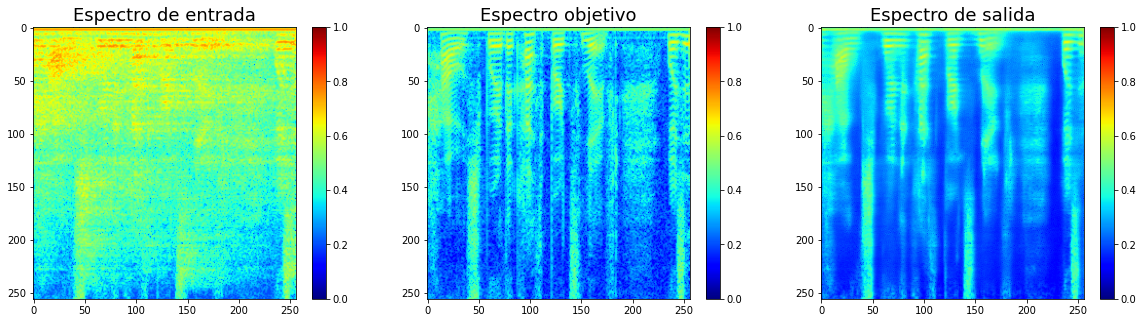

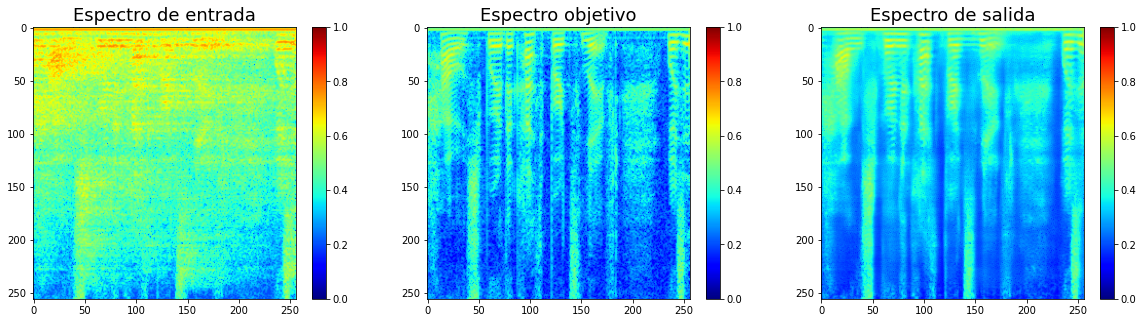

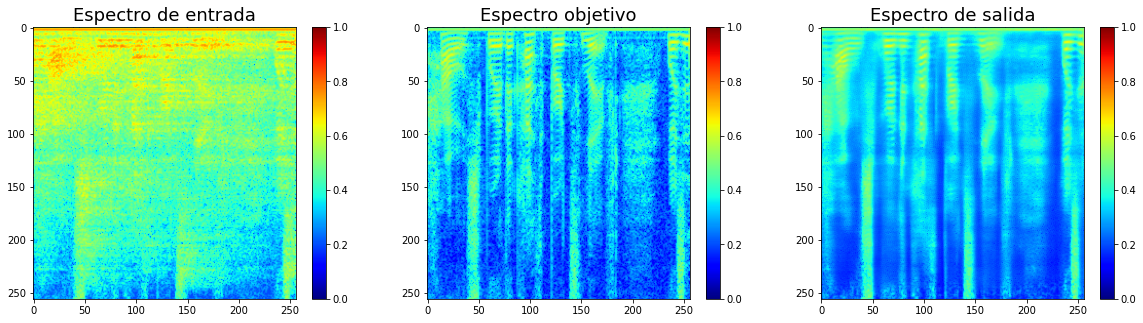

In [11]:
import glob
CARPETA = '/home/martin/deep-dereverb/model/ckpts/mezcla/'
pesos = glob.glob(CARPETA+'*.hdf5')
pesos.sort()
labels = ['Epoca '+p.split('/')[-1].split('.')[1][:2] for p in pesos]

modelo = autoencoder()
reverb_list = glob.glob('/home/martin/deep-dereverb/data/train/real/**/*.npy', recursive=True)
clean_list =glob.glob('/home/martin/deep-dereverb/data/train/clean/**/*.npy', recursive=True)
reverb_list.sort(); clean_list.sort()

for idx,peso in enumerate(pesos):
    modelo.load_weights(peso)
    audio_in = np.load(reverb_list[1])
    audio_target= np.load(clean_list[1])
    
    espectro_in = gen_stft(audio_in)
    espectro_target = gen_stft(audio_target)
    
    espectro_out = modelo.predict([espectro_in.reshape(1,256,256)])
    espectro_out = espectro_out.reshape(256,256)
    
    plt.figure(idx, figsize=(20,5))
    plt.subplot(1,3,1);plt.title('Espectro de entrada', size=18)
    plt.imshow(espectro_in, aspect='auto',vmin=0, vmax=1, cmap='jet');plt.colorbar()
    plt.subplot(1,3,2);plt.title('Espectro objetivo', size=18)
    plt.imshow(espectro_target, aspect='auto',vmin=0, vmax=1, cmap='jet');plt.colorbar()
    plt.subplot(1,3,3);plt.title('Espectro de salida', size=18)
    plt.imshow(espectro_out, aspect='auto',vmin=0, vmax=1, cmap='jet');plt.colorbar()
    plt.savefig('funcionamiento.png')
    

In [31]:
def predict_model(data, modelo):                                                                                                             
  output = [layer.name for layer in modelo.layers]                                                                                           
  outputs = []                                                                                                                               
  output_names = []                                                                                                                          
  inputs = []                                                                                                                                
  input_names = []                                                                                                                           
  for layer in modelo.layers:                                                                                                                
      if hasattr(layer,'is_placeholder'):                                                                                                    
          inputs.append(layer.output)                                                                                                        
          input_names.append(layer.name)                                                                                                     
      elif layer.name in output:                                                                                                             
          outputs.append(layer.output)                                                                                                       
          output_names.append(layer.name)                                                                                                    
      else:                                                                                                                                  
          pass                                                                                                                               
  predict_fn = tf.keras.backend.function(inputs = inputs,outputs=outputs)                                                                    
  activations = predict_fn(data)                                                                                                             
  activations = {name: act for name, act in zip(output_names,activations)}                                                                   
  print('orden de las entradas: /\n',input_names)                                                                                            
  return activations 
PESOS = '/home/martin/deep-dereverb/model/ckpts/mezcla/weights.03-0.0022.hdf5'
modelo = autoencoder()
modelo.load_weights(PESOS)
actvs = predict_model([espectro_in.reshape(1,256,256)], modelo)

orden de las entradas: /
 ['Entrada_reverb']


In [32]:
actvs.keys()

dict_keys(['tf.expand_dims', 'CONV1', 'ACT1', 'CONV2', 'BATCH2', 'ACT2', 'CONV3', 'BATCH3', 'ACT3', 'CONV4', 'BATCH4', 'ACT4', 'CONV5', 'BATCH5', 'ACT5', 'CONV6', 'BATCH6', 'ACT6', 'CONV7', 'BATCH7', 'ACT7', 'CONV8', 'BATCH8', 're_lu', 'up_sampling2d', 'CONV9', 'BATCH9', 'dropout', 're_lu_1', 'add', 'up_sampling2d_1', 'CONV10', 'BATCH10', 'dropout_1', 're_lu_2', 'add_1', 'up_sampling2d_2', 'CONV11', 'BATCH11', 'dropout_2', 're_lu_3', 'add_2', 'up_sampling2d_3', 'CONV12', 'BATCH12', 're_lu_4', 'add_3', 'up_sampling2d_4', 'CONV13', 'BATCH13', 're_lu_5', 'add_4', 'up_sampling2d_5', 'CONV14', 'BATCH14', 're_lu_6', 'add_5', 'up_sampling2d_6', 'CONV15', 'BATCH15', 're_lu_7', 'add_6', 'up_sampling2d_7', 'SALIDA_DEL_DECODER', 're_lu_8', 'CLEAN_PREDICT'])

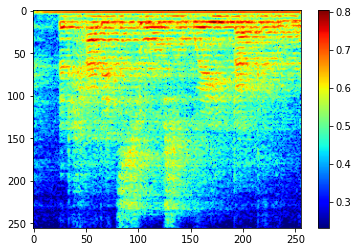

In [33]:
# Recupero la entrada
entrada = actvs['tf.expand_dims'][0,:,:,0]
plt.imshow(entrada, aspect='auto', cmap='jet')
plt.colorbar()

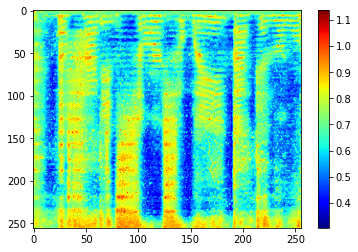

In [37]:
# Recupero la mascara
mascara = actvs['SALIDA_DEL_DECODER'][0,:,:,0]
plt.imshow(mascara, aspect='auto', cmap='jet')
plt.colorbar()
mascara = np.ones(mascara.shape)

In [38]:
espectro_out = entrada * mascara
audio_out = frame_to_raw(espectro_out)

In [39]:
IPython.display.Audio(audio_out, rate = 16000)